### About the notebook

Most of the heavly lifting in the notebook is done by a cool prototyping lib "fastai" (more info at fast.ai and docs.fast.ai/) and PyTorch.
The notebook only serves as an example to kickstart your further developement to train a baseline model on the generated data by Unity Engine.
It uses an unet, resnet34. You can go for a deeper network if you have capable hardware, just simply tweak the constants under "Constants" chapter.

### PREVIOUSLY:

- Fixed mask generation in Unity; built basic unet_learner; best without transfer;
- Started assembling unity hook; server running ok; made the test functions. Problem - cant make a fastapi response with a picture; trying base64 encoding but something fails...
- Make Unity hook
- Train via "go big" method;
- inference realtime: update colored overlay in unity
- turn off some batch augmentations / image tmfs: accuracy, diceloss, training speed checks
- split GoBig part into another notebook
- add normalization to batch_tfms
- real life images check

### TODO:

- pass accuracy / probability to via API Unity
- top loss heat map?

### Tried:

- Resnet 50; resnet 14, but 50 is too big; 14 seems too inaccurate;
- Transfer learning sucked - because unity scene not realistic
- <500 images dont train good; >1k images performs quite well; >2k recommended;
- had problems with different image encodings in Unity and fastai; read through PILMask code in fastai to figure it out; it was a Unity issue in labeling had to be linear encoding

### Constants
Pick the depending on the machine you use to train and personal preferences.

- ```batchsize``` sets how big a single train back is, default could be = 64 (fits well for 11G graphics card and input pic resolution 64x64)
- ```use_transfer``` sets if we use transfer learning or not. Default is False, because unrealistic scenes in Unity are trained not very good.
For real life applications try to make as realistic of a scene as possible (lighting, shaddows, ambient lights, textures, etc.)
- ```model_arch```
How deep your network is. My 11 gig card handles resnet34 well, asuming batchsize = 64 and pic size (64,64). If you have more capable hardware (or use cloud computing), you can try go higher.

In [1]:
batchsize = 80
use_transfer = False
from fastai.vision.all import resnet34 as model_arch
small_epochs = 20 #30
save_name = "unity_resnet34"

other choices include: resnet50, resnet101, etc. More info at: https://docs.fast.ai/vision.models.xresnet.html and 
https://fastai1.fast.ai/vision.models.html

### Imports

In [2]:
import pandas as pd
from fastai.vision.all import *
import importlib
import pathlib
import os
import PIL
from numpy import asarray
from notebook_libs.helper_funcs import show_superimposed
from fastinference.onnx import *

In [3]:
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")
path

'/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~'

In [4]:
codes = pd.read_csv(os.path.join(path,'labels.csv'))
#codes.head()
#codes.shape

In [5]:
fnames = get_image_files(os.path.join(path,"screenshots"))
lnames = get_image_files(os.path.join(path,"labels"))
print(fnames[0])
print(lnames[0])

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/labels/2831.png


# Data Loading

## Creating dataloaders

In [6]:
room_dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes.LabelName)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=[*aug_transforms(flip_vert = False, max_lighting = 0.1, max_warp=0.05, size=(64,64)), Normalize])
dls = room_dblock.dataloaders(os.path.join(path,"screenshots"), path=path, bs=batchsize)

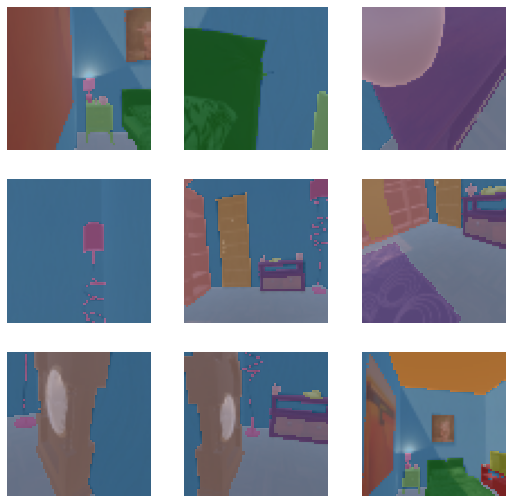

In [7]:
dls.show_batch(vmin=0, vmax=25, cmap='tab20')

## Debuging loaded label images

### See if superimposed is correct

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/labels/2831.png
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png


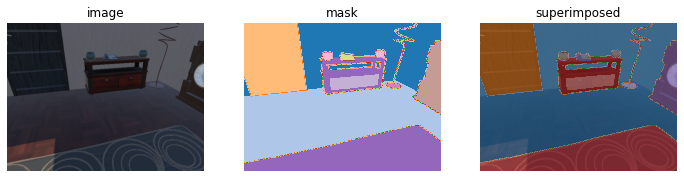

In [8]:
print(lnames[0])
print(fnames[0])
show_superimposed(fnames[0], lnames[0])

### Check if any labels are missing unintentionally

In [9]:
from notebook_libs.helper_funcs import n_code, n_codes, mask_check, debug_label

In [10]:
len_codes = n_codes(lnames)
vals = [v-1 for k, v in len_codes.items()]
#len_codes

In [11]:
#find an out of bounds label name:
for fname in lnames:
    [print(fname, "  label!?:", v) for v in n_code(fname) if v > len(len_codes)+5]

In [12]:
if(len(len_codes) == len(codes.LabelName)):
    print("OK! All items appeared in the dataset! OK!")
else:
    print("Not all items appeared inside the dataset! Please generate larger picture set!")
    print("Missing:")
    codes_mask = ~codes["LabelName"].index.isin(vals)
    print(codes["LabelName"][codes_mask])

OK! All items appeared in the dataset! OK!


In [13]:
#Check if PILMask / Unity doesnt ruin something. These must match:
print(mask_check(lnames[0]))
print(n_code(lnames[0]))

[1]
{1}


In [14]:
#Detections:
#codes["LabelName"][mask_check(lnames[0])]

### If needed, print a mask value
Helper function to show a picture with a precise mask pixel value.
Show by opening the file in the viewer.

In [15]:
#debug_label(lnames[0], 1)

In [16]:
#See mask color schema
#plt.imshow(np.array([[0, 1, 2, 4, 5, 6]]), vmin=0, vmax=6, cmap='tab20')

# Training

In [17]:
#changed moms, previously: moms=(0.85, 0.75, 0.85)
learn = unet_learner(dls, model_arch, pretrained = use_transfer, moms=(0.95, 0.85, 0.95), n_out=len(codes["LabelName"])+1, metrics=[foreground_acc, DiceMulti()]).to_fp16()

In [18]:
#learn.summary()

In [19]:
if use_transfer:
    #learn.lr_find() #uncomment this line if you want to tweak LR before running fill learning. Can use this after every unfreeze step.
    #learn.fit_one_cycle(small_epochs//2, slice(3e-5, 5e-3))
    #learn.freeze_to(-1)
    #learn.fit_one_cycle(small_epochs//2, slice(3e-5, 5e-3))
    #learn.unfreeze()
    #learn.fit_one_cycle(small_epochs//2, slice(3e-5, 5e-3))
    pass

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,1.558123,1.721917,0.594969,0.066020,00:18
1,1.106748,0.705372,0.771086,0.266224,00:15
2,0.874628,0.567699,0.834280,0.349697,00:17
3,0.714604,0.578335,0.826251,0.358077,00:15
4,0.627350,0.473317,0.844341,0.478722,00:17
5,0.533168,0.428734,0.871868,0.499783,00:15
6,0.442185,0.298405,0.910380,0.619858,00:15
7,0.370444,0.226707,0.929996,0.669258,00:16
8,0.337373,0.251773,0.925339,0.661223,00:15
9,0.291973,0.227001,0.926787,0.697619,00:14


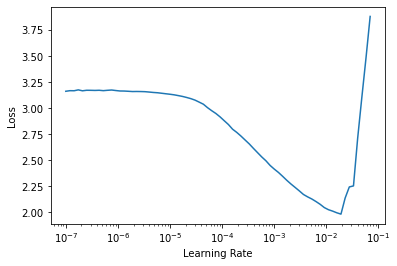

In [20]:
if not use_transfer:
    learn.lr_find()
    learn.fit_one_cycle(small_epochs, slice(3e-5, 5e-3)) #15
    pass

### Saving small model

In [21]:
#learn.save(save_name+"_64x")
#learn.export("models/"+save_name)

onnx_path = os.path.join(path, "models/", save_name+"_onnx_64x")
learn.to_onnx(onnx_path)

# Results

#### Metrics helper functions

In [22]:
#Source: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

#### Metrics Plots

In [23]:
#learn.recorder.plot_metrics()

#### Predicting

In [24]:
from fastai.learner import load_learner
import os

from notebook_libs.helper_funcs import show_masked_original_size, path_to_image_bytes, load_image_from_bytes

_test_upload_file = ""
for root, dirs, files in os.walk(
    path, topdown=True, onerror=None, followlinks=False
):
    _test_upload_file = os.path.join(root, files[0])
model_path = os.path.join(path, "models", "unity_resnet34")

print(model_path)
print(_test_upload_file)

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/models/unity_resnet34
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png


In [25]:
learner = load_learner(model_path)
img_bytes = path_to_image_bytes(_test_upload_file)
image = load_image_from_bytes(img_bytes)

In [26]:
ima = load_image_from_bytes(path_to_image_bytes(_test_upload_file))
print(ima.shape)
#a = np.delete(ima, 3, axis=2)
#print(a.shape)

(480, 640, 3)


(480, 640)


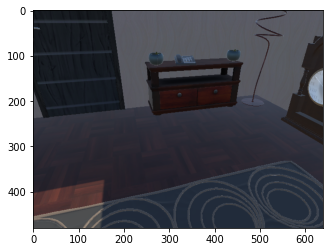

In [27]:
base_img = PILImage.create(fnames[0])
base_img_size = base_img.shape
print(base_img_size)
img_to_learner = np.array(base_img)
plt.imshow(img_to_learner)

In [28]:
print(base_img.shape)
pred = learner.predict(np.array(base_img))[0]
print(pred.shape)
#pred.show()

(480, 640)


/home/carrotpie/code/classB/classB_env/lib/python3.6/site-packages/fastai/metrics.py:376: RuntimeWarning: Mean of empty slice


torch.Size([1, 24, 64, 64])


Here we see that prediction output mask is smaller than original if final training tier is not done on bigger resolution. It will in fact be smaller as long as the final resolution is not of the original camera capture texture resolution. In that case we need to rescale it back up, so that our API returns correct size texture. How we do it can be found in a helper function ```show_masked_original_size```:

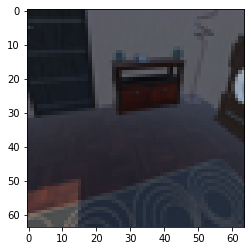

In [29]:
base_img_small = base_img.resize((64,64))
plt.imshow(np.array(base_img_small))
#plt.imshow(np.array(pred), alpha=0.25)

In [30]:
#show_masked_original_size(base_img, learner)

#### Interpertation

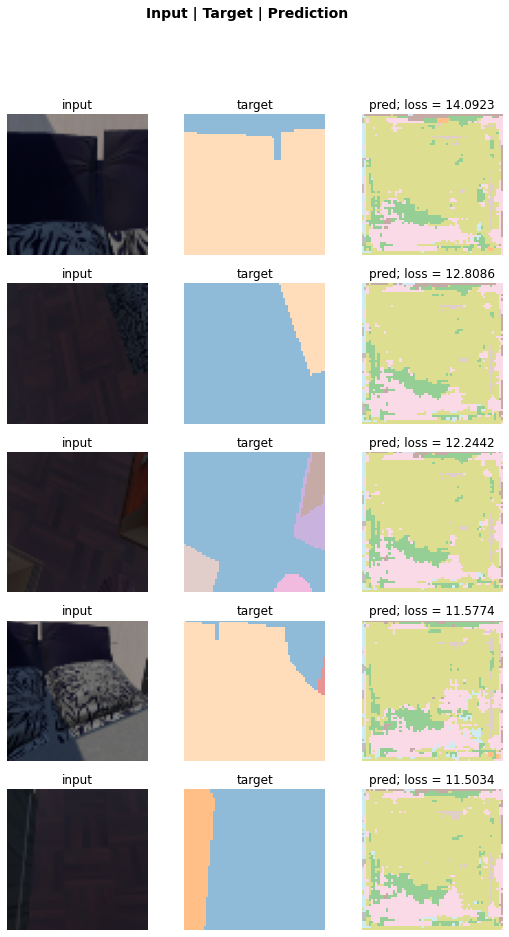

In [31]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=5)

# ONNX inference

In [43]:
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")

In [44]:
from fastai.vision.all import PILImage, get_image_files
from fastinference.onnx import *


In [45]:
import torchvision.transforms as transforms
import os
import pathlib

In [46]:
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")
save_name = "unity_resnet34"

In [47]:
fnames = get_image_files(os.path.join(path,"screenshots"))

In [48]:
onnx_path = os.path.join(path, "models/", save_name+"_onnx_64x")
onnx_learn = fastONNX(onnx_path)

using cpu: False


In [49]:
pil_img = PILImage.create(fnames[0])
#base_img = np.array(pil_img)
#base_img = (np.array(pil_img)).astype(np.float32) / 255
resize = transforms.Resize([64, 64])
pil_img = resize(pil_img)
print(pil_img.shape)
to_tensor = transforms.ToTensor()
ten_image = to_tensor(pil_img)
print(ten_image.shape)
ten_image = ten_image.unsqueeze_(0)
print(ten_image.shape)


(64, 64)
torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])


In [50]:
#type(base_img)

In [51]:
#base_img

In [52]:
%%time
model_output = onnx_learn.predict(ten_image)

<class 'torch.Tensor'>  predict shape:  torch.Size([1, 3, 64, 64])
CPU times: user 36.9 ms, sys: 8.4 ms, total: 45.3 ms
Wall time: 116 ms


In [53]:
model_output[0].shape

(24, 64, 64)